In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import datetime
import tensorflow_datasets as tfds
import tensorflow as tf
import os
import time
import numpy as np
import matplotlib.pyplot as plt

try:
  !pip install -q tf-nightly 
except Exception:
  pass
dataset=[]
#print(tf.__version__)
file='../../dataset/translate-dataset/'
file='./drive/My Drive/correct_dataset/'
source_token='./drive/My Drive/correct_dataset/source'
target_token='./drive/My Drive/correct_dataset/target'
train_dataset=[]
train_target=[]
val_dataset=[]
val_target=[]
test_dataset=[]
test_target=[]
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = './drive/My Drive/correct_dataset/' + current_time + '/train'
test_log_dir = './drive/My Drive/correct_dataset/' + current_time + '/test'
train_summary_writer = tf.compat.v2.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.compat.v2.summary.create_file_writer(test_log_dir)
with open(file+'training_set.txt') as f:
    for each in f.readlines():
        if each[:4]== 'src:':
            train_dataset.append(each[4:])
            #print("1"+each[4:])
        else:
            train_target.append(each[4:])
            #print("2"+each[4:])
    print(len(train_dataset))
with open(file +'val_set.txt') as f:
    for each in f.readlines():
        if each[:4] == 'src:':
            test_dataset.append(each[4:])
        else:
            test_target.append(each[4:])

    print(len(test_dataset))



train_dataset=tf.data.Dataset.from_tensor_slices((train_dataset,train_target))
test_dataset=tf.data.Dataset.from_tensor_slices((test_dataset,test_target))
#val_dataset=tf.data.Dataset.from_tensor_slices((val_dataset,val_target))


"""从训练数据集创建自定义子词分词器（subwords tokenizer）。"""
if os.path.exists(source_token):
    tokenizer_en=tfds.features.text.SubwordTextEncoder.load_from_file(source_token)
else:
    tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for en,pt in train_dataset), target_vocab_size=2**13)
    tokenizer_en.save_to_file(source_token)
tokenizer_pt=tokenizer_en
"""if os.path.exists(target_token):
    tokenizer_pt=tfds.features.text.SubwordTextEncoder.load_from_file(target_token)
else:
    tokenizer_pt = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for en,pt in train_dataset), target_vocab_size=2 ** 13)
    tokenizer_pt.save_to_file(target_token)
"""


"""如果单词不在词典中，则分词器（tokenizer）通过将单词分解为子词来对字符串进行编码。"""


BUFFER_SIZE = 20000
BATCH_SIZE = 256

"""将开始和结束标记（token）添加到输入和目标。"""

def encode(lang1, lang2):
    lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(
        lang1.numpy()) + [tokenizer_pt.vocab_size + 1]

    lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
        lang2.numpy()) + [tokenizer_en.vocab_size + 1]

    return lang1, lang2


"""Note：为了使本示例较小且相对较快，删除长度大于40个标记的样本。"""

MAX_LENGTH = 20


def filter_max_length(x, y, max_length=MAX_LENGTH):
    return tf.logical_and(tf.size(x) <= max_length,
                          tf.size(y) <= max_length)


"""`.map()` 内部的操作以图模式（graph mode）运行，`.map()` 接收一个不具有 numpy 属性的图张量（graph tensor）。该`分词器（tokenizer）`需要将一个字符串或 Unicode 符号，编码成整数。因此，您需要在 `tf.py_function` 内部运行编码过程，`tf.py_function` 接收一个 eager 张量，该 eager 张量有一个包含字符串值的 numpy 属性。"""


def tf_encode(en,pt):
    return tf.py_function(encode, [en,pt], [tf.int64, tf.int64])

#val_dataset=val_dataset.map(tf_encode)
test_dataset=test_dataset.map(tf_encode)
train_dataset = train_dataset.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
# 将数据集缓存到内存中以加快读取速度。
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(
    BATCH_SIZE, padded_shapes=([-1], [-1]))
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

test_dataset=test_dataset.filter(filter_max_length).padded_batch(
    BATCH_SIZE, padded_shapes=([-1], [-1]))
#val_dataset = val_dataset.filter(filter_max_length).padded_batch(
#    BATCH_SIZE, padded_shapes=([-1], [-1]))

test_dataset=test_dataset.cache()
#val_dataset=val_dataset.cache()


"""## 位置编码（Positional encoding）

因为该模型并不包括任何的循环（recurrence）或卷积，所以模型添加了位置编码，为模型提供一些关于单词在句子中相对位置的信息。

位置编码向量被加到嵌入（embedding）向量中。嵌入表示一个 d 维空间的标记，在 d 维空间中有着相似含义的标记会离彼此更近。但是，嵌入并没有对在一句话中的词的相对位置进行编码。因此，当加上位置编码后，词将基于*它们含义的相似度以及它们在句子中的位置*，在 d 维空间中离彼此更近。

参看 [位置编码](https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb) 的 notebook 了解更多信息。计算位置编码的公式如下：

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$
"""


def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates


def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)

    # 将 sin 应用于数组中的偶数索引（indices）；2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # 将 cos 应用于数组中的奇数索引；2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)



"""## 遮挡（Masking）

遮挡一批序列中所有的填充标记（pad tokens）。这确保了模型不会将填充作为输入。该 mask 表明填充值 `0` 出现的位置：在这些位置 mask 输出 `1`，否则输出 `0`。
"""


def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # 添加额外的维度来将填充加到
    # 注意力对数（logits）。
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)


"""前瞻遮挡（look-ahead mask）用于遮挡一个序列中的后续标记（future tokens）。换句话说，该 mask 表明了不应该使用的条目。

这意味着要预测第三个词，将仅使用第一个和第二个词。与此类似，预测第四个词，仅使用第一个，第二个和第三个词，依此类推。
"""


def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)


"""## 按比缩放的点积注意力（Scaled dot product attention）

<img src="https://tensorflow.google.cn/images/tutorials/transformer/scaled_attention.png" width="500" alt="scaled_dot_product_attention">

Transformer 使用的注意力函数有三个输入：Q（请求（query））、K（主键（key））、V（数值（value））。用于计算注意力权重的等式为：

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

点积注意力被缩小了深度的平方根倍。这样做是因为对于较大的深度值，点积的大小会增大，从而推动 softmax 函数往仅有很小的梯度的方向靠拢，导致了一种很硬的（hard）softmax。

例如，假设 `Q` 和 `K` 的均值为0，方差为1。它们的矩阵乘积将有均值为0，方差为 `dk`。因此，*`dk` 的平方根*被用于缩放（而非其他数值），因为，`Q` 和 `K` 的矩阵乘积的均值本应该为 0，方差本应该为1，这样会获得一个更平缓的 softmax。

遮挡（mask）与 -1e9（接近于负无穷）相乘。这样做是因为遮挡与缩放的 Q 和 K 的矩阵乘积相加，并在 softmax 之前立即应用。目标是将这些单元归零，因为 softmax 的较大负数输入在输出中接近于零。
"""


def scaled_dot_product_attention(q, k, v, mask):
    """计算注意力权重。
    q, k, v 必须具有匹配的前置维度。
    k, v 必须有匹配的倒数第二个维度，例如：seq_len_k = seq_len_v。
    虽然 mask 根据其类型（填充或前瞻）有不同的形状，
    但是 mask 必须能进行广播转换以便求和。

    参数:
      q: 请求的形状 == (..., seq_len_q, depth)
      k: 主键的形状 == (..., seq_len_k, depth)
      v: 数值的形状 == (..., seq_len_v, depth_v)
      mask: Float 张量，其形状能转换成
            (..., seq_len_q, seq_len_k)。默认为None。

    返回值:
      输出，注意力权重
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # 缩放 matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # 将 mask 加入到缩放的张量上。
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

        # softmax 在最后一个轴（seq_len_k）上归一化，因此分数
    # 相加等于1。
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights


"""当 softmax 在 K 上进行归一化后，它的值决定了分配到 Q 的重要程度。

输出表示注意力权重和 V（数值）向量的乘积。这确保了要关注的词保持原样，而无关的词将被清除掉。
"""


np.set_printoptions(suppress=True)



# 这条 `请求（query）符合第二个`主键（key）`，
# 因此返回了第二个`数值（value）`。


"""## 多头注意力（Multi-head attention）

<img src="https://tensorflow.google.cn/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


多头注意力由四部分组成：
*    线性层并分拆成多头。
*    按比缩放的点积注意力。
*    多头及联。
*    最后一层线性层。

每个多头注意力块有三个输入：Q（请求）、K（主键）、V（数值）。这些输入经过线性（Dense）层，并分拆成多头。 

将上面定义的 `scaled_dot_product_attention` 函数应用于每个头（进行了广播（broadcasted）以提高效率）。注意力这步必须使用一个恰当的 mask。然后将每个头的注意力输出连接起来（用`tf.transpose` 和 `tf.reshape`），并放入最后的 `Dense` 层。

Q、K、和 V 被拆分到了多个头，而非单个的注意力头，因为多头允许模型共同注意来自不同表示空间的不同位置的信息。在分拆后，每个头部的维度减少，因此总的计算成本与有着全部维度的单个注意力头相同。
"""


class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """分拆最后一个维度到 (num_heads, depth).
        转置结果使得形状为 (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention,
                                        perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights


"""创建一个 `MultiHeadAttention` 层进行尝试。在序列中的每个位置 `y`，`MultiHeadAttention` 在序列中的所有其他位置运行所有8个注意力头，在每个位置y，返回一个新的同样长度的向量。"""


"""## 点式前馈网络（Point wise feed forward network）

点式前馈网络由两层全联接层组成，两层之间有一个 ReLU 激活函数。
"""


def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])


"""## 编码与解码（Encoder and decoder）

<img src="https://tensorflow.google.cn/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

Transformer 模型与标准的[具有注意力机制的序列到序列模型（sequence to sequence with attention model）](nmt_with_attention.ipynb)，遵循相同的一般模式。

* 输入语句经过 `N` 个编码器层，为序列中的每个词/标记生成一个输出。
* 解码器关注编码器的输出以及它自身的输入（自注意力）来预测下一个词。

### 编码器层（Encoder layer）

每个编码器层包括以下子层：

1.   多头注意力（有填充遮挡）
2.   点式前馈网络（Point wise feed forward networks）。

每个子层在其周围有一个残差连接，然后进行层归一化。残差连接有助于避免深度网络中的梯度消失问题。

每个子层的输出是 `LayerNorm(x + Sublayer(x))`。归一化是在 `d_model`（最后一个）维度完成的。Transformer 中有 N 个编码器层。
"""


class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2


# (batch_size, input_seq_len, d_model)

"""### 解码器层（Decoder layer）

每个解码器层包括以下子层：

1.   遮挡的多头注意力（前瞻遮挡和填充遮挡）
2.   多头注意力（用填充遮挡）。V（数值）和 K（主键）接收*编码器输出*作为输入。Q（请求）接收*遮挡的多头注意力子层的输出*。
3.   点式前馈网络

每个子层在其周围有一个残差连接，然后进行层归一化。每个子层的输出是 `LayerNorm(x + Sublayer(x))`。归一化是在 `d_model`（最后一个）维度完成的。

Transformer 中共有 N 个解码器层。

当 Q 接收到解码器的第一个注意力块的输出，并且 K 接收到编码器的输出时，注意力权重表示根据编码器的输出赋予解码器输入的重要性。换一种说法，解码器通过查看编码器输出和对其自身输出的自注意力，预测下一个词。参看按比缩放的点积注意力部分的演示。
"""


class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,
             look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2





"""### 编码器（Encoder）

`编码器` 包括：
1.   输入嵌入（Input Embedding）
2.   位置编码（Positional Encoding）
3.   N 个编码器层（encoder layers）

输入经过嵌入（embedding）后，该嵌入与位置编码相加。该加法结果的输出是编码器层的输入。编码器的输出是解码器的输入。
"""


class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                 maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding,
                                                self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        # 将嵌入和位置编码相加。
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)




"""### 解码器（Decoder）

`解码器`包括：
1.   输出嵌入（Output Embedding）
2.   位置编码（Positional Encoding）
3.   N 个解码器层（decoder layers）

目标（target）经过一个嵌入后，该嵌入和位置编码相加。该加法结果是解码器层的输入。解码器的输出是最后的线性层的输入。
"""


class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
                 maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,
             look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                   look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i + 1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i + 1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights



"""## 创建 Transformer

Transformer 包括编码器，解码器和最后的线性层。解码器的输出是线性层的输入，返回线性层的输出。
"""


class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                 target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                               input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                               target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training, enc_padding_mask,
             look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights


"""## 配置超参数（hyperparameters）

为了让本示例小且相对较快，已经减小了*num_layers、 d_model 和  dff* 的值。 

Transformer 的基础模型使用的数值为：*num_layers=6*，*d_model = 512*，*dff = 2048*。关于所有其他版本的 Transformer，请查阅[论文](https://arxiv.org/abs/1706.03762)。

Note：通过改变以下数值，您可以获得在许多任务上达到最先进水平的模型。
"""

num_layers =6
d_model = 512
dff = 2048
num_heads = 8

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

"""## 优化器（Optimizer）

根据[论文](https://arxiv.org/abs/1706.03762)中的公式，将 Adam 优化器与自定义的学习速率调度程序（scheduler）配合使用。

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$
"""


class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

"""## 损失函数与指标（Loss and metrics）

由于目标序列是填充（padded）过的，因此在计算损失函数时，应用填充遮挡非常重要。
"""

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)


train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

"""## 训练与检查点（Training and checkpointing）"""

transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size,
                          pe_input=input_vocab_size,
                          pe_target=target_vocab_size,
                          rate=dropout_rate)


def create_masks(inp, tar):
    # 编码器填充遮挡
    enc_padding_mask = create_padding_mask(inp)

    # 在解码器的第二个注意力模块使用。
    # 该填充遮挡用于遮挡编码器的输出。
    dec_padding_mask = create_padding_mask(inp)

    # 在解码器的第一个注意力模块使用。
    # 用于填充（pad）和遮挡（mask）解码器获取到的输入的后续标记（future tokens）。
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask


"""创建检查点的路径和检查点管理器（manager）。这将用于在每 `n` 个周期（epochs）保存检查点。"""

checkpoint_path = file+"/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# 如果检查点存在，则恢复最新的检查点。
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

"""目标（target）被分成了 tar_inp 和 tar_real。tar_inp 作为输入传递到解码器。`tar_real` 是位移了 1 的同一个输入：在 `tar_inp` 中的每个位置，`tar_real` 包含了应该被预测到的下一个标记（token）。

例如，`sentence` = "SOS A lion in the jungle is sleeping EOS"

`tar_inp` =  "SOS A lion in the jungle is sleeping"

`tar_real` = "A lion in the jungle is sleeping EOS"

Transformer 是一个自回归（auto-regressive）模型：它一次作一个部分的预测，然后使用到目前为止的自身的输出来决定下一步要做什么。

在训练过程中，本示例使用了 teacher-forcing 的方法（就像[文本生成教程](./text_generation.ipynb)中一样）。无论模型在当前时间步骤下预测出什么，teacher-forcing 方法都会将真实的输出传递到下一个时间步骤上。

当 transformer 预测每个词时，*自注意力（self-attention）*功能使它能够查看输入序列中前面的单词，从而更好地预测下一个单词。

为了防止模型在期望的输出上达到峰值，模型使用了前瞻遮挡（look-ahead mask）。
"""

EPOCHS = 101

# 该 @tf.function 将追踪-编译 train_step 到 TF 图中，以便更快地
# 执行。该函数专用于参数张量的精确形状。为了避免由于可变序列长度或可变
# 批次大小（最后一批次较小）导致的再追踪，使用 input_signature 指定
# 更多的通用形状。

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]
@tf.function(input_signature=train_step_signature)
def test_step(inp,tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)


    predictions, _ = transformer(inp, tar_inp,
                                     True,
                                     enc_padding_mask,
                                     combined_mask,
                                     dec_padding_mask)
    loss = loss_function(tar_real, predictions)


    train_loss(loss)
    train_accuracy(tar_real, predictions)

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp,
                                     True,
                                     enc_padding_mask,
                                     combined_mask,
                                     dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(tar_real, predictions)

"""葡萄牙语作为输入语言，英语为目标语言。"""

"""葡萄牙语作为输入语言，英语为目标语言。"""
mini_loss=100
num_loss=0
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()

    # inp -> portuguese, tar -> english
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', train_accuracy.result(), step=epoch)

    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print('Saving checkpoint for epoch {} at {}'.format(epoch + 1,
                                                            ckpt_save_path))

    print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1,
                                                        train_loss.result(),
                                                        train_accuracy.result()))

    print('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))
    start = time.time()
    train_loss.reset_states()
    train_accuracy.reset_states()
    for (batch, (inp, tar)) in enumerate(test_dataset):
        test_step(inp, inp)
    with test_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss.result(), step=epoch)
        tf.summary.scalar('accuracy', train_accuracy.result(), step=epoch)
    if train_loss.result()<min_loss:
        min_loss=train_loss.result()
        num_loss=0
    else:
        num_loss=num_loss+1

    print(' Test Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1,
                                                              train_loss.result(),
                                                              train_accuracy.result()))

    print('Time taken for 1 test epoch: {} secs\n'.format(time.time() - start))
    if num_loss>5:
        break
"""## 评估（Evaluate）

以下步骤用于评估：

* 用葡萄牙语分词器（`tokenizer_pt`）编码输入语句。此外，添加开始和结束标记，这样输入就与模型训练的内容相同。这是编码器输入。
* 解码器输入为 `start token == tokenizer_en.vocab_size`。
* 计算填充遮挡和前瞻遮挡。
* `解码器`通过查看`编码器输出`和它自身的输出（自注意力）给出预测。
* 选择最后一个词并计算它的 argmax。
* 将预测的词连接到解码器输入，然后传递给解码器。
* 在这种方法中，解码器根据它预测的之前的词预测下一个。

Note：这里使用的模型具有较小的能力以保持相对较快，因此预测可能不太正确。要复现论文中的结果，请使用全部数据集，并通过修改上述超参数来使用基础 transformer 模型或者 transformer XL。
"""

"""在本教程中，您已经学习了位置编码，多头注意力，遮挡的重要性以及如何创建一个 transformer。

尝试使用一个不同的数据集来训练 transformer。您可也可以通过修改上述的超参数来创建基础 transformer 或者 transformer XL。您也可以使用这里定义的层来创建 [BERT](https://arxiv.org/abs/1810.04805) 并训练最先进的模型。此外，您可以实现 beam search 得到更好的预测。
"""



     |████████████████████████████████| 533.2MB 28kB/s 
     |████████████████████████████████| 460kB 43.0MB/s 
     |████████████████████████████████| 2.8MB 50.7MB/s 
     |████████████████████████████████| 2.9MB 63.3MB/s 
     |████████████████████████████████| 778kB 64.7MB/s 
ERROR: tensorflow 1.15.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow~=2.1.0, but you'll have tensorflow 1.15.0 which is incompatible.
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow-addons~=0.7.0, but you'll have tensorflow-addons 0.8.3 which is incompatible.
179727
20273


RuntimeError: ignored

In [ ]:
import tensorflow as tf
print(tf.__version__)

1.15.0


In [ ]:
import tensorflow as tf
a=[1,2]
b=tf.expand_dims(a,0)

def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # 添加额外的维度来将填充加到
    # 注意力对数（logits）。
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)
res=create_padding_mask(b)
print(res)


tf.Tensor([[[[0. 0.]]]], shape=(1, 1, 1, 2), dtype=float32)


In [ ]:

def evaluate(inp_sentence):
    start_token = [tokenizer_pt.vocab_size]
    end_token = [tokenizer_pt.vocab_size + 1]

    # 输入语句是葡萄牙语，增加开始和结束标记
    inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token
    encoder_input = tf.expand_dims(inp_sentence, 0)

    # 因为目标是英语，输入 transformer 的第一个词应该是
    # 英语的开始标记。
    decoder_input = [tokenizer_en.vocab_size]
    output = tf.expand_dims(decoder_input, 0)
    train_accuracy.reset_states()
    for i in range(MAX_LENGTH):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, output)

        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input,
                                                     output,
                                                     False,
                                                     enc_padding_mask,
                                                     combined_mask,
                                                     dec_padding_mask)

        # 从 seq_len 维度选择最后一个词
        
        predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 如果 predicted_id 等于结束标记，就返回结果
        if predicted_id == tokenizer_en.vocab_size + 1:
            return tf.squeeze(output, axis=0), attention_weights

        # 连接 predicted_id 与输出，作为解码器的输入传递到解码器。
        output = tf.concat([output, predicted_id], axis=-1)
    result=output
    '''
    print(encoder_input)
    paddings=tf.constant([[0,0],[0,MAX_LENGTH-encoder_input.get_shape().as_list()[1]+1]])
    print(paddings)
    encoder_input=tf.pad(encoder_input,paddings,mode='CONSTANT')
    print(output,encoder_input)
    output=tf.expand_dims(output,0)
    print
    train_accuracy(encoder_input,output)
    loss=loss_function(encoder_input,output)
        
    print("acc:{},loss:{}",train_accuracy,loss)
    '''
    return tf.squeeze(result, axis=0), attention_weights


def plot_attention_weights(attention, sentence, result, layer):
    fig = plt.figure(figsize=(16, 8))

    sentence = tokenizer_pt.encode(sentence)

    attention = tf.squeeze(attention[layer], axis=0)

    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head + 1)

        # 画出注意力权重
        ax.matshow(attention[head][:-1, :], cmap='viridis')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(sentence) + 2))
        ax.set_yticks(range(len(result)))

        ax.set_ylim(len(result) - 1.5, -0.5)

        ax.set_xticklabels(
            ['<start>'] + [tokenizer_pt.decode([i]) for i in sentence] + ['<end>'],
            fontdict=fontdict, rotation=90)

        ax.set_yticklabels([tokenizer_en.decode([i]) for i in result
                            if i < tokenizer_en.vocab_size],
                           fontdict=fontdict)

        ax.set_xlabel('Head {}'.format(head + 1))

    plt.tight_layout()
    plt.show()


def translate(sentence, plot=''):
    result, attention_weights = evaluate(sentence)

    predicted_sentence = tokenizer_en.decode([i for i in result
                                              if i < tokenizer_en.vocab_size])

    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(predicted_sentence))

    if plot:
        plot_attention_weights(attention_weights, sentence, result, plot)




"""## 总结"""
num=0
translate("this is problem we have to solve .")
with open(file+"test.txt",'w') as f:
    for each in train_target:
      result,_=evaluate(each)
      predicted_sentence = tokenizer_en.decode([i for i in result
                                              if i < tokenizer_en.vocab_size])

      f.writelines(each)
      f.writelines(predicted_sentence)
      print(num)
      num=num+1
      if num ==100:
        break
  

Input: this is problem we have to solve .
Predicted translation: this is problem we have to solve . .problem we have to solve .success . . . .
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [ ]:
!pip install tensorflow-gpu


In [ ]:
import tensorflow as tf
print(tf.__version__)

/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

1.15.0


In [ ]:
!nvidia-smi

Wed Jan 13 02:23:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

--2021-01-13 02:23:57--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  55.5MB/s    in 1.4s    

2021-01-13 02:23:58 (55.5 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



read train files: 25000
read test files: 25000
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 380, 32)           121600    
_________________________________________________________________
dropout_4 (Dropout)          (None, 380, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_4 (Dense)              (None, 256)               4352      
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 129,345
Trainable params: 129,345
Non-trainable params: 0
_

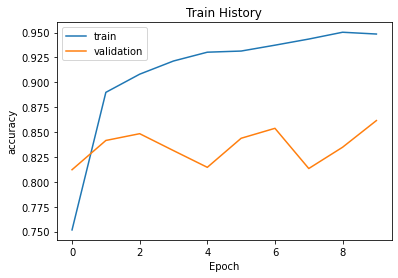

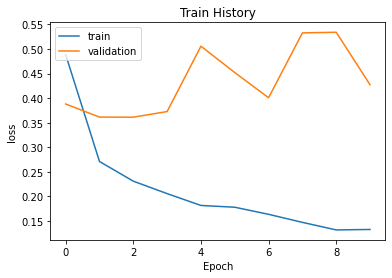

782/782 [==============================] - 7s 8ms/step - loss: 0.4034 - accuracy: 0.8652
[0.9900332]
[0.00769656]
[0.0042432]
[0.7617404]
[0.03312397]
[0.20990895]
[0.00792131]
[0.00729761]
[0.78378636]
[0.14973794]


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


I liked this film a lot. The actors were great, particularly Potente, who is different in every role; Fürmann, who is also able to play anyone; and Loos, who spices things up (she is also a talented singer - she sings the song "My Truth", heard when one character cranks up the stereo in the lab).Anatomie is a good horror flick, which pays attention to its characters. It is also very gory at times, and the set design is innovative. It is too bad they had to make a sequel, which is nowhere near the original.On a side note, two other things definitely worth mentioning. The DVD is not dubbed, which makes for a better experience of the film. Also, make sure to keep watching after the final credits start rolling.
label真实值: 正面的 预测结果: 正面的
"Plots With A View" of 2002 is a delightful little comedy like only the British could do it. The film's sense of humor is both mildly morbid and black and yet very lovable and sometimes very slapstick-ish. It's the only film by director Nick Hurran I've seen 

"\n'负面的'\n"

In [ ]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
import numpy as np
import re
re_tag = re.compile(r'<[^>]+>')
 
def rm_tags(text):
    return re_tag.sub('', text)
 
import os
def read_files(filetype):
    path = "./aclImdb/"
    file_list=[]
 
    positive_path=path + filetype+"/pos/"
    for f in os.listdir(positive_path):
        file_list+=[positive_path+f]
    
    negative_path=path + filetype+"/neg/"
    for f in os.listdir(negative_path):
        file_list+=[negative_path+f]
        
    print('read',filetype, 'files:',len(file_list))
       
    all_labels = ([1] * 12500 + [0] * 12500) 
    
    all_texts  = []
    
    for fi in file_list:
        with open(fi,encoding='utf8') as file_input:
            all_texts += [rm_tags(" ".join(file_input.readlines()))]
            
    return np.array(all_labels),np.array(all_texts)
 
y_train,train_text=read_files("train")
y_test,test_text=read_files("test")
token = Tokenizer(num_words=3800)
token.fit_on_texts(train_text)
x_train_seq = token.texts_to_sequences(train_text)
x_test_seq  = token.texts_to_sequences(test_text)
x_train = sequence.pad_sequences(x_train_seq, maxlen=380)
x_test  = sequence.pad_sequences(x_test_seq,  maxlen=380)
 
#####建立模型
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN
from keras.layers import LSTM
 
model = Sequential()
 
model.add(Embedding(output_dim=32,
                    input_dim=3800, 
                    input_length=380))
model.add(Dropout(0.35))
 
model.add(LSTM(units=16))
 
model.add(Dense(units=256,activation='relu' ))
 
model.add(Dropout(0.35))
 
model.add(Dense(units=1,activation='sigmoid' ))
 
model.summary()
 
#####训练模型
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
 
train_history =model.fit(x_train, y_train,batch_size=100, 
                         epochs=10,verbose=2,
                         validation_split=0.2)
 
import matplotlib.pyplot as plt
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
 
show_train_history(train_history,'accuracy','val_accuracy')
show_train_history(train_history,'loss','val_loss')
 
#####评估模型的准确率
scores = model.evaluate(x_test, y_test, verbose=1)
scores[1]
 
#####预测概率
probility=model.predict(x_test)
probility[:10]
 
for p in probility[12500:12510]:
    print(p)
 
#####预测结果
predict=model.predict_classes(x_test)
 
predict[:10]
predict.shape
predict_classes=predict.reshape(25000)
predict_classes
 
#####查看预测结果
SentimentDict={1:'正面的',0:'负面的'}
def display_test_Sentiment(i):
    print(test_text[i])
    print('label真实值:',SentimentDict[y_test[i]],
          '预测结果:',SentimentDict[predict_classes[i]])
 
display_test_Sentiment(2)
 
display_test_Sentiment(3)
predict_classes[12500:12510]
display_test_Sentiment(12502)
'''
注：以下是程序输出（不包括此句）
First of all I hate those moronic rappers, who could'nt act if they had a gun pressed against their foreheads. All they do is curse and shoot each other and acting like cliché'e version of gangsters.The movie doesn't take more than five minutes to explain what is going on before we're already at the warehouse There is not a single sympathetic character in this movie, except for the homeless guy, who is also the only one with half a brain.Bill Paxton and William Sadler are both hill billies and Sadlers character is just as much a villain as the gangsters. I did'nt like him right from the start.The movie is filled with pointless violence and Walter Hills specialty: people falling through windows with glass flying everywhere. There is pretty much no plot and it is a big problem when you root for no-one. Everybody dies, except from Paxton and the homeless guy and everybody get what they deserve.The only two black people that can act is the homeless guy and the junkie but they're actors by profession, not annoying ugly brain dead rappers.Stay away from this crap and watch 48 hours 1 and 2 instead. At lest they have characters you care about, a sense of humor and nothing but real actors in the cast.
label真实值: 负面的 预测结果: 负面的
'''
 
#预测新的影评
input_text='''
I can't vote because I have not watched this movie yet. I've been wanting to watch this movie since the time they announced making it which is about 2 years ago (!)
I was planning to go with the family to see the anticipated movie but my nieces had school exams at the opening time so we all decided to wait for the next weekend. I was utterly shocked to learn yesterday that they pulled the movie from the Kuwaiti theaters "temporarily" so that the outrageous censorship system can remove some unwanted scenes.
The controversial gay "moment" according to my online research is barely there, so I can't find any logical reason for all the fuss that's been going on. And it was bad enough when fanatics and haters tried (in vain) to kill the movie with low ratings and negative reviews even before it was in the cinemas and I'm pretty sure most of those trolls never got the chance to watch the movie at that time.
Based on the trailers, I think the movie is very promising and entertaining and you can't simply overlook the tremendous efforts made to bring this beloved tale to life. To knock down hundreds of people's obvious hard work with unprofessional critique and negative reviews just for the sake of hatred is unfathomable. I hope people won't judge a movie before having the experience of watching it in the first place.
Impatiently waiting for the Kuwaiti cinemas to bring back the movie... 
'''
input_seq = token.texts_to_sequences([input_text])
pad_input_seq  = sequence.pad_sequences(input_seq , maxlen=380)
predict_result=model.predict_classes(pad_input_seq)
SentimentDict[predict_result[0][0]]
'''
'负面的'
'''


# 新段落